In [1]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [2]:
WDAY_csv = Path("../SaaS_Data/Workday_WDAY.csv")

In [3]:
WDAY_df = pd.read_csv(WDAY_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
WDAY_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,136.550003,142.500000,135.850006,139.199997,139.199997,4244000
2018-08-16,139.729996,141.830002,139.160004,140.050003,140.050003,1949600
2018-08-17,139.449997,142.770004,138.639999,142.649994,142.649994,1538700
2018-08-20,142.699997,144.220001,141.660004,143.289993,143.289993,2192300
2018-08-21,144.000000,147.800003,143.850006,145.009995,145.009995,1758300


In [5]:
WDAY_df.sort_index(ascending=True, inplace=True)

In [6]:
WDAY_df = WDAY_df.rename(columns={'Close': 'Close'})
WDAY_df = WDAY_df[['Close']]
WDAY_df

,Close
Date,
2018-08-15,139.199997
2018-08-16,140.050003
2018-08-17,142.649994
2018-08-20,143.289993
2018-08-21,145.009995
...,...
2021-08-09,234.190002
2021-08-10,230.699997
2021-08-11,231.369995


In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(WDAY_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[139.199997 140.050003 142.649994 143.289993 145.009995 146.139999
  145.679993 151.       151.679993 152.259995 153.779999 153.809998
  154.539993 156.690002 142.210007 144.520004 144.929993 143.660004
  146.149994 148.210007 150.539993 151.070007 144.729996 143.679993
  140.660004 141.660004 138.630005 141.5      143.789993 144.509995
  145.970001 145.979996 145.869995 142.899994 145.660004 139.759995
  139.970001 132.419998 131.669998 124.300003 124.75     128.309998
  127.       134.190002 137.25     130.429993 127.699997 129.720001
  128.779999 122.110001 125.839996 120.650002 122.75     128.020004
  133.020004 137.889999 132.839996 130.320007 134.979996 144.240005
  145.990005 139.929993 133.100006 135.059998 132.389999 136.179993
  134.229996 124.07     126.809998 133.100006 135.259995 140.229996
  138.75     145.830002 145.300003 164.       167.800003 165.020004
  168.130005 160.429993 159.679993 162.940002 165.520004 164.649994
  162.029999 153.759995 155.710

In [9]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [10]:
y_train

array([[166.179993],
       [167.960007],
       [167.460007],
       [163.330002],
       [164.470001],
       [165.339996],
       [166.580002],
       [172.080002],
       [170.770004],
       [171.660004],
       [171.199997],
       [175.580002],
       [172.5     ],
       [166.690002],
       [172.619995],
       [181.529999],
       [186.059998],
       [186.779999],
       [189.289993],
       [188.479996],
       [186.610001],
       [189.410004],
       [190.300003],
       [189.520004],
       [187.75    ],
       [188.539993],
       [190.789993],
       [192.740005],
       [188.649994],
       [189.470001],
       [194.699997],
       [196.229996],
       [195.119995],
       [197.449997],
       [197.929993],
       [189.139999],
       [179.220001],
       [181.960007],
       [182.429993],
       [181.75    ],
       [181.610001],
       [185.5     ],
       [187.339996],
       [186.160004],
       [187.039993],
       [186.690002],
       [187.509995],
       [191.5

In [11]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [16]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
4/4 [==============================] - 9s 489ms/step - loss: 0.1994
Epoch 2/20
4/4 [==============================] - 2s 436ms/step - loss: 0.0606
Epoch 3/20
4/4 [==============================] - 2s 454ms/step - loss: 0.0721
Epoch 4/20
4/4 [==============================] - 2s 439ms/step - loss: 0.0377
Epoch 5/20
4/4 [==============================] - 2s 419ms/step - loss: 0.0262
Epoch 6/20
4/4 [==============================] - 2s 440ms/step - loss: 0.0169
Epoch 7/20
4/4 [==============================] - 2s 422ms/step - loss: 0.0160
Epoch 8/20
4/4 [==============================] - 2s 430ms/step - loss: 0.0192
Epoch 9/20
4/4 [==============================] - 2s 445ms/step - loss: 0.0160
Epoch 10/20
4/4 [==============================] - 2s 444ms/step - loss: 0.0162
Epoch 11/20
4/4 [==============================] - 2s 427ms/step - loss: 0.0137
Epoch 12/20
4/4 [==============================] - 2s 442ms/step - loss: 0.0137
Epoch 13/20
4/4 [==============================] 

In [17]:
model.evaluate(X_test, y_test, verbose=0)

0.027442757040262222

In [18]:
predicted = model.predict(X_test)

In [19]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [20]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [21]:
WDAY_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = WDAY_df.index[-len(real_prices): ])

WDAY_actual_predicted.head()

,Actual,Predicted
Date,,
2020-07-31,180.580002,185.215454
2020-08-03,180.919998,184.716980
2020-08-04,181.589996,184.191711
2020-08-05,181.490005,183.666656
2020-08-06,183.990005,183.161896


In [22]:
WDAY_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,235.720001,221.410080
2021-08-10,234.190002,221.456711
2021-08-11,230.699997,221.499176
2021-08-12,231.369995,221.485596
2021-08-13,235.330002,221.409424


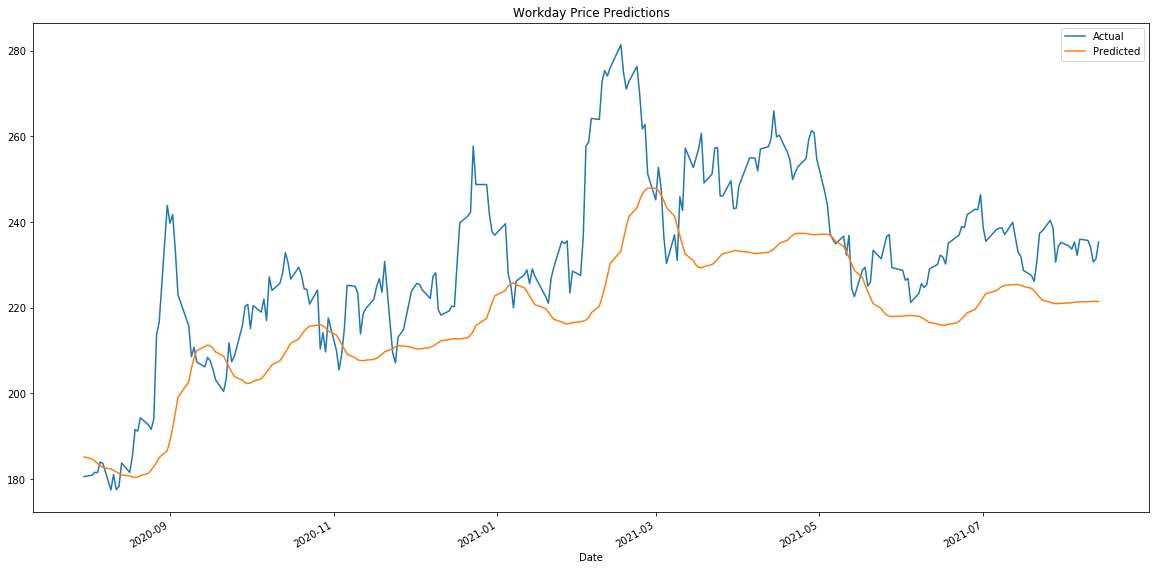

In [24]:
WDAY_actual_predicted.plot(figsize=(20,10), title="Workday Price Predictions")